In [1]:
import data_utils as util
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import pandas as pd
import exp_util

# data preprocessing

In [2]:
#######################################################
# Load the feature header
#######################################################
import csv

# read the csv file
feature_names = []
with open('./data/header.csv') as f:
    reader = csv.reader(f)
    for line in reader:
        feature_names.append(line)

# Dirty tricks to clean up the feature names
feature_names = feature_names[0]
feature_names = list(map(lambda x: x.replace(' ', '_'), feature_names))
feature_names[0] = 'PharmGKB_Subject_ID' # manual fix to remove a character in f...[0]

In [3]:
####################################################################
# Load the dataframe into X; clean up some unnecessary columns 
####################################################################

# Load data and process column names
df = pd.read_csv('./data/warfarin_with_dose.csv', names = feature_names)
#keep_default_na=False)
df.columns = [c.replace(' ', '_') for c in df.columns]

# Extract the label (Warfarin dose) from the rest of the features
y = df.Therapeutic_Dose_of_Warfarin
X = df.drop('Therapeutic_Dose_of_Warfarin',axis=1)
feature_names.remove('Therapeutic_Dose_of_Warfarin')

# Drop Subject_ID (irrelevant) and Medication (different to encode)
X = X.drop('PharmGKB_Subject_ID',axis=1)
X = X.drop('Medications',axis=1)
X = X.drop('Comorbidities',axis=1)
feature_names.remove('PharmGKB_Subject_ID')
feature_names.remove('Medications')
feature_names.remove('Comorbidities')

In [4]:
y = y>30 #this line converts labels to binary

In [5]:
####################################################################
# Encode different features with numeric/label/onehot encodings 
####################################################################
numeric_features = ['Height_(cm)',
                    'Weight_(kg)',
                    'Target_INR',
                    'INR_on_Reported_Therapeutic_Dose_of_Warfarin',
                    ]
label_features =   ['Age',
                    'Estimated_Target_INR_Range_Based_on_Indication']
categorical_features = [f for f in feature_names \
                        if f not in numeric_features and f not in label_features]

for feat in categorical_features:
    X[feat] = X[feat].astype(str)

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

label_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='0-missing')),
    ('ordinal', OrdinalEncoder())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore',sparse=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('lab', label_transformer, label_features),
        ('cat', categorical_transformer, categorical_features)]
)


In [7]:
X_transformed = preprocessor.fit_transform(X)

In [8]:
X_transformed.shape

(5528, 259)

# Train Validation Test Split

In [9]:
# Split the data into train, val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=5)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.2, random_state = 5)

# Learning

In [ ]:
# Linear regression
from sklearn.linear_model import LinearRegression

lr_regressor = LinearRegression(fit_intercept = True)
lr_regressor.fit(X_train, y_train)
print(lr_regressor.score(X_val, y_val))
print(lr_regressor.score(X_train, y_train))

y_pred = lr_regressor.predict(X_val)
print(mean_squared_error(y_val,y_pred))
print(np.mean(y_val))
coef = lr_regressor.coef_
print(coef)

In [ ]:
# SVM
from sklearn.svm import SVR

svm_regressor = SVR(kernel='rbf', gamma='auto')
svm_regressor.fit(X_train, y_train)
svm_regressor.score(X_val, y_val)

In [ ]:
# SVM with various hyperparameters
from sklearn.svm import SVR

#initialise arrays to store the scores 
svm_score_train = np.zeros((7,1))
svm_score_val = np.zeros((7,1))

for i, C in enumerate((1000,100,10,1, 0.1, 0.01,0.001)):
    svm_regressor = SVR(kernel='rbf', gamma='auto', C=C)
    svm_regressor.fit(X_train,y_train)
    svm_score_train[i,:] = svm_regressor.score(X_train,y_train)
    svm_score_val[i,:] = svm_regressor.score(X_val,y_val)
    
print('training score \n', svm_score_train)
print('validation score \n', svm_score_val)




In [ ]:
# Ridge Regression
from sklearn.linear_model import Ridge

#initialise arrays to store the scores 
ridge_score_train = np.zeros(7)
ridge_score_val = np.zeros(7)

for i, C in enumerate((1000,100,10,1, 0.1, 0.01,0.001)):
    ridge_regressor = Ridge(alpha=1/C, fit_intercept = True)
    ridge_regressor.fit(X_train,y_train)
    ridge_score_train[i] = ridge_regressor.score(X_train,y_train)
    ridge_score_val[i] = ridge_regressor.score(X_val,y_val)
    
print('training score \n', ridge_score_train)
print('validation score \n', ridge_score_val)

best_ridge = Ridge(alpha = 1, fit_intercept = True)
best_ridge.fit(X_train,y_train)
y_pred = best_ridge.predict(X_val)
print(np.sqrt(mean_squared_error(y_val,y_pred)))
# print(np.mean(y_val))

# print(best_ridge.coef_)

In [ ]:
xaxis = [0.001,0.01,0.1,1,10,100,1000] #values of lambda used
plt.plot(xaxis,ridge_score_train, label = 'training')
plt.plot(xaxis,ridge_score_val, label = 'validation')
plt.xlabel('lambda')
plt.ylabel('score')
plt.legend()
plt.xscale('log')
plt.title('Accuracy vs Lambda - Ridge Penalty')
plt.savefig('Ridge.png')

In [ ]:
# Lasso Regression
from sklearn.linear_model import Lasso

#initialise arrays to store the scores 
lasso_score_train = np.zeros(7)
lasso_score_val = np.zeros(7)

for i, C in enumerate((1000,100,10,1, 0.1, 0.01,0.001)):
    lasso_regressor = Lasso(alpha=1/C, fit_intercept = True)
    lasso_regressor.fit(X_train,y_train)
    lasso_score_train[i] = lasso_regressor.score(X_train,y_train)
    lasso_score_val[i] = lasso_regressor.score(X_val,y_val)
    
print('training score \n', lasso_score_train)
print('validation score \n', lasso_score_val)

best_lasso = Lasso(alpha = 0.01, fit_intercept = True)
best_lasso.fit(X_train,y_train)
y_pred = best_lasso.predict(X_val)
print(np.sqrt(mean_squared_error(y_val,y_pred)))
# print(np.mean(y_val))

# print(best_lasso.coef_)

In [ ]:
xaxis = [0.001,0.01,0.1,1,10,100,1000] #values of lambda used
plt.plot(xaxis,lasso_score_train, label = 'training')
plt.plot(xaxis,lasso_score_val, label = 'validation')
plt.xlabel('lambda')
plt.ylabel('score')
plt.legend()
plt.xscale('log')
plt.title('Accuracy vs Lambda - Lasso Penalty')
plt.savefig('Lasso.png')

In [ ]:
# MLP regressor
from sklearn.neural_network import MLPRegressor

nn_regressor = MLPRegressor() #use default settings
nn_regressor.fit(X_train, y_train)
print(nn_regressor.score(X_val, y_val))
print(nn_regressor.score(X_train, y_train))

y_pred = nn_regressor.predict(X_val)
print(mean_squared_error(y_val,y_pred))
print(np.mean(y_val))



In [ ]:
# non-nested cross validation using RBF SVM
from sklearn.model_selection import GridSearchCV

rbf = SVR(kernel='rbf')
gammas = np.logspace(-6, 0, 7)
params = {'gamma': gammas}
gridcv = GridSearchCV(estimator=rbf, param_grid=params, cv=5)
gridcv.fit(X_trainval, y_trainval)
scores_mean = gridcv.cv_results_['mean_test_score']
scores_sd = gridcv.cv_results_['std_test_score']
print('highest accuracy score is',gridcv.best_score_)
model = gridcv.best_estimator_

In [ ]:
# non-nested cross validation using Ridge
from sklearn.model_selection import GridSearchCV

ridge_regressor = Ridge(fit_intercept = True)
params={'alpha': [25,10,4,2,1.0,0.8,0.5,0.3,0.2,0.1,0.05,0.02,0.01]}

gridcv = GridSearchCV(estimator=ridge_regressor, param_grid=params, cv=10)
gridcv.fit(X_trainval, y_trainval)
scores_mean = gridcv.cv_results_['mean_test_score']
scores_sd = gridcv.cv_results_['std_test_score']
print('highest accuracy score is',gridcv.best_score_)
model = gridcv.best_estimator_

## classification results

In [ ]:
exp_util.val_bin_accuracy(lr_regressor, X_val, y_val)

In [ ]:
exp_util.val_bin_accuracy(best_ridge, X_val, y_val)

In [ ]:
exp_util.val_bin_accuracy(best_lasso, X_val, y_val)

In [ ]:
exp_util.val_bin_accuracy_two_classes(best_ridge, X_val, y_val)

In [ ]:
exp_util.val_bin_accuracy_two_classes(best_lasso, X_val, y_val)

In [ ]:
exp_util.val_bin_accuracy_two_classes(nn_regressor, X_val, y_val)

# generates detailed results in classification

In [ ]:
loss, TP, FP, TN, FN = exp_util.val_bin_accuracy_with_con_matrix(best_ridge, X_val, y_val)
print(loss)
print(TP)
print(FP)
print(TN)
print(FN)

print(TP + FP + TN + FN)

In [ ]:
accuracy, sensitivity, specificity, precision_plus, precision_minus =exp_util.get_classification_metrics(
    best_ridge, X_val, y_val)
print(accuracy) #benchmark = 66%
print(sensitivity) #benchmark = 63%
print(specificity) #benchmark = 73%
print(precision_plus) #benchmark = 81%
print(precision_minus) #benchmark = 50%

# While we seem to do better in many of the metrics, we obtained lower precision (plus). Interesting.
# To discuss, which metric is more important in our context? 

# plotting ROC curve

In [ ]:
# Ridge Regression
from sklearn.linear_model import Ridge

#initialise arrays to store the scores 
ridge_score_train = np.zeros(7)
ridge_score_val = np.zeros(7)
ridge_score_specificity = np.zeros(7)
ridge_score_sensitivity = np.zeros(7)

for i, C in enumerate((1000,100,10,1, 0.1, 0.01,0.001)):
    ridge_regressor = Ridge(alpha=1/C, fit_intercept = True)
    ridge_regressor.fit(X_train,y_train)
    ridge_score_train[i] = ridge_regressor.score(X_train,y_train)
    ridge_score_val[i] = ridge_regressor.score(X_val,y_val)
    
    accuracy, sensitivity, specificity, precision_plus, precision_minus =exp_util.get_classification_metrics(
    ridge_regressor, X_val, y_val)
    ridge_score_sensitivity[i] = sensitivity
    ridge_score_specificity[i] = specificity
    
print('training score \n', ridge_score_train)
print('validation score \n', ridge_score_val)
print('specificity \n', ridge_score_specificity)
print('sensitivity \n', ridge_score_sensitivity)



xaxis = [0.001,0.01,0.1,1,10,100,1000] #values of lambda used
plt.plot(ridge_score_sensitivity,ridge_score_specificity)
plt.xlabel('sensitivity')
plt.ylabel('specificity')
plt.legend()
plt.title('Specificity vs Sensitivity - Ridge Penalty')
plt.savefig('Ridge_class.png')

## classification models

In [23]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, auc, roc_auc_score

log_regressor = LogisticRegression()
log_regressor.fit(X_train,y_train)

#predict = log_regressor.predict(X_val) #this implements default threshold of 0.5

threshold = np.arange(0,1.1,0.1)
accuracy = np.zeros(len(threshold))
sensitivity = np.zeros(len(threshold))
specificity = np.zeros(len(threshold))
precision = np.zeros(len(threshold))

for i in range(len(threshold)):
    
    predict = (log_regressor.predict_proba(X_val)[:,1] >= threshold[i]).astype(int)

    TN, FP, FN, TP = confusion_matrix(y_val,predict).ravel()

    accuracy[i] = np.mean(predict == y_val)
    sensitivity[i] = TP / (TP + FN)
    specificity[i] = TN / (TN + FP)
    precision[i] = TP / (TP + FP)

recall = sensitivity.copy()

print('accuracy values')
print(accuracy)
print('sensitivity values')
print(sensitivity)
print('specificity values')
print(specificity)



accuracy values
[0.43841808 0.63050847 0.70960452 0.7480226  0.7819209  0.79548023
 0.77740113 0.74915254 0.7039548  0.64519774 0.56158192]
sensitivity values
[1.         0.96649485 0.93814433 0.8814433  0.83505155 0.76804124
 0.64690722 0.5257732  0.38402062 0.21907216 0.        ]
specificity values
[0.         0.36820926 0.53118712 0.64386318 0.74044266 0.81690141
 0.87927565 0.92354125 0.95372233 0.9778672  1.        ]


C:\Users\zhiqi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zhiqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in longlong_scalars


auc
0.857451409487855


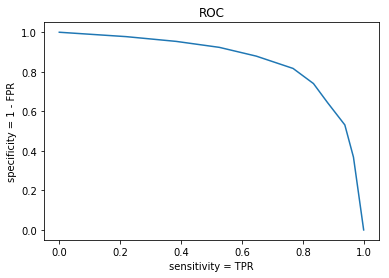

In [24]:
#note TPR = sensitivity, FPR = 1 - specificity
#FPR is important because we want to avoid overdosing
plt.plot(sensitivity, specificity)
plt.xlabel('sensitivity = TPR')
plt.ylabel('specificity = 1 - FPR')
plt.title('ROC')
plt.savefig('logreg_baseline_ROC.png')

print('auc')
print(auc(sensitivity,specificity)) #auc takes in arguments (x,y)

In [ ]:
plt.plot(recall, precision)
plt.xlabel('recall = TPR')
plt.ylabel('precision')
plt.title('PRC')

print('auc')
print(auc(recall,precision))


## prediction on test set for unregularized model

In [ ]:
#suppose best unregularized model corresponds to threshold = 0.6

threshold = 0.6
predict = (log_regressor.predict_proba(X_test)[:,1] >= threshold).astype(int)

TN, FP, FN, TP = confusion_matrix(y_test,predict).ravel()

accuracy = np.mean(predict == y_test)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)

recall = sensitivity.copy()

print('classification on test set')
print('accuracy')
print(accuracy)
print('sensitivity')
print(sensitivity)
print('specificity')
print(specificity)


# classification with L2 regularization

In [25]:
# Logistic Regression with L2 regularization

log_regressor_L2reg = LogisticRegression(penalty = 'l2', C = 1) #set L2 penalty
log_regressor_L2reg.fit(X_train,y_train)

#predict = log_regressor.predict(X_val) #this implements default threshold of 0.5

threshold = np.arange(0,1.1,0.1)
accuracy = np.zeros(len(threshold))
sensitivity = np.zeros(len(threshold))
specificity = np.zeros(len(threshold))
precision = np.zeros(len(threshold))

for i in range(len(threshold)):
    
    predict = (log_regressor_L2reg.predict_proba(X_val)[:,1] >= threshold[i]).astype(int)

    TN, FP, FN, TP = confusion_matrix(y_val,predict).ravel()

    accuracy[i] = np.mean(predict == y_val)
    sensitivity[i] = TP / (TP + FN)
    specificity[i] = TN / (TN + FP)
    precision[i] = TP / (TP + FP)

recall = sensitivity.copy()

print('accuracy values')
print(accuracy)
print('sensitivity values')
print(sensitivity)
print('specificity values')
print(specificity)

accuracy values
[0.43841808 0.63050847 0.70960452 0.7480226  0.7819209  0.79548023
 0.77740113 0.74915254 0.7039548  0.64519774 0.56158192]
sensitivity values
[1.         0.96649485 0.93814433 0.8814433  0.83505155 0.76804124
 0.64690722 0.5257732  0.38402062 0.21907216 0.        ]
specificity values
[0.         0.36820926 0.53118712 0.64386318 0.74044266 0.81690141
 0.87927565 0.92354125 0.95372233 0.9778672  1.        ]


C:\Users\zhiqi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zhiqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in longlong_scalars


auc
0.857451409487855


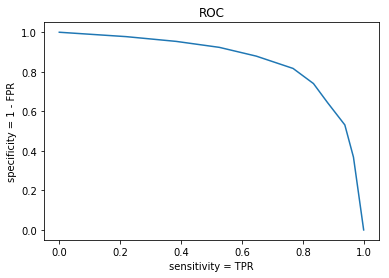

In [26]:
#note TPR = sensitivity, FPR = 1 - specificity
#FPR is important because we want to avoid overdosing
plt.plot(sensitivity, specificity)
plt.xlabel('sensitivity = TPR')
plt.ylabel('specificity = 1 - FPR')
plt.title('ROC')

print('auc')
print(auc(sensitivity,specificity)) #auc takes in arguments (x,y)

auc
nan


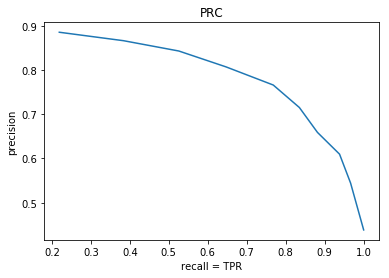

In [27]:
plt.plot(recall, precision)
plt.xlabel('recall = TPR')
plt.ylabel('precision')
plt.title('PRC')

print('auc')
print(auc(recall,precision))

In [28]:
# Logistic Regression with L2 regularization
alpha = np.logspace(-3,3,7)
C = 1/alpha
threshold = np.arange(0,1.1,0.1)
accuracy = np.zeros( (len(C) , len(threshold)) )
sensitivity = np.zeros( (len(C) , len(threshold)) )
specificity = np.zeros( (len(C) , len(threshold)) )
precision = np.zeros( (len(C) , len(threshold)) )

for k in range(len(alpha)):
    log_regressor_L2reg = LogisticRegression(penalty = 'l2', C = C[k], solver = 'lbfgs') #set L2 penalty, C is inverse of reg strength
    log_regressor_L2reg.fit(X_train,y_train)

    #predict = log_regressor.predict(X_val) #this implements default threshold of 0.5



    for i in range(len(threshold)):

        predict = (log_regressor_L2reg.predict_proba(X_val)[:,1] >= threshold[i]).astype(int)

        TN, FP, FN, TP = confusion_matrix(y_val,predict).ravel()

        accuracy[k,i] = np.mean(predict == y_val)
        sensitivity[k,i] = TP / (TP + FN)
        specificity[k,i] = TN / (TN + FP)
        precision[k,i] = TP / (TP + FP)

recall = sensitivity.copy()

print('accuracy values')
print(accuracy)
print('sensitivity values')
print(sensitivity)
print('specificity values')
print(specificity)

C:\Users\zhiqi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\zhiqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\zhiqi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\zhiqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\zhiqi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\zhiqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in longlong_scalars
C

accuracy values
[[0.43841808 0.63276836 0.70960452 0.75819209 0.77627119 0.7920904
  0.7740113  0.75932203 0.71073446 0.65310734 0.56158192]
 [0.43841808 0.63276836 0.71186441 0.7559322  0.7740113  0.79096045
  0.77514124 0.76384181 0.71299435 0.6519774  0.56158192]
 [0.43841808 0.63615819 0.70734463 0.7559322  0.77740113 0.79322034
  0.7740113  0.76158192 0.71412429 0.65423729 0.56158192]
 [0.43841808 0.63050847 0.71073446 0.74915254 0.78418079 0.7920904
  0.77740113 0.75028249 0.7039548  0.64632768 0.56158192]
 [0.43841808 0.61355932 0.6960452  0.74576271 0.77853107 0.79096045
  0.76723164 0.73785311 0.70282486 0.62259887 0.56158192]
 [0.43841808 0.57853107 0.65988701 0.72881356 0.76158192 0.78418079
  0.75480226 0.71864407 0.65649718 0.59322034 0.56158192]
 [0.43841808 0.45310734 0.56384181 0.65649718 0.73446328 0.75254237
  0.70169492 0.62485876 0.57288136 0.56158192 0.56158192]]
sensitivity values
[[1.         0.96134021 0.93041237 0.88402062 0.82989691 0.76030928
  0.65979381 0.5

C:\Users\zhiqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in longlong_scalars


auc
[0.8554523  0.85591124 0.85635462 0.85766921 0.85708581 0.85131926
 0.82730662]


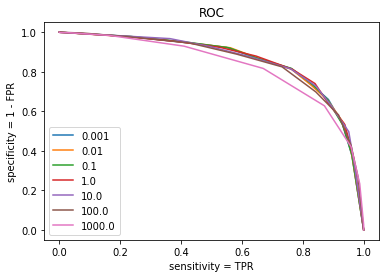

In [29]:
#note TPR = sensitivity, FPR = 1 - specificity
#FPR is important because we want to avoid overdosing
num = len(alpha)
AUC = np.zeros(num)
for i in range(num):
    plt.plot(sensitivity[i,:], specificity[i,:], label = alpha[i])
    AUC[i] = auc(sensitivity[i,:],specificity[i,:])
    
plt.xlabel('sensitivity = TPR')
plt.ylabel('specificity = 1 - FPR')
plt.legend()
plt.title('ROC')
plt.savefig('logreg_L2regularized_ROC.png')

print('auc')
print(AUC) #auc takes in arguments (x,y)

In [30]:
best_reg_strength = alpha[np.argmax(AUC)]
print(best_reg_strength)
best_auc = AUC[np.argmax(AUC)]
print(best_auc)

1.0
0.8576692111431475


# classification with L1 regularization

In [58]:
# Logistic Regression with L1 regularization
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, auc, roc_auc_score


log_regressor_L1reg = LogisticRegression(penalty = 'l1', C = 10) #set L1 penalty
log_regressor_L1reg.fit(X_train,y_train)

#predict = log_regressor.predict(X_val) #this implements default threshold of 0.5

threshold = np.arange(0,1.1,0.1)
accuracy = np.zeros(len(threshold))
sensitivity = np.zeros(len(threshold))
specificity = np.zeros(len(threshold))
precision = np.zeros(len(threshold))

for i in range(len(threshold)):
    
    predict = (log_regressor_L1reg.predict_proba(X_val)[:,1] >= threshold[i]).astype(int)

    TN, FP, FN, TP = confusion_matrix(y_val,predict).ravel()

    accuracy[i] = np.mean(predict == y_val)
    sensitivity[i] = TP / (TP + FN)
    specificity[i] = TN / (TN + FP)
    precision[i] = TP / (TP + FP)

recall = sensitivity.copy()

print('accuracy values')
print(accuracy)
print('sensitivity values')
print(sensitivity)
print('specificity values')
print(specificity)

C:\Users\zhiqi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy values
[0.43841808 0.63163842 0.71299435 0.75932203 0.78418079 0.78870056
 0.78079096 0.75480226 0.71186441 0.65423729 0.56158192]
sensitivity values
[1.         0.96391753 0.93298969 0.88402062 0.83505155 0.75773196
 0.65463918 0.54123711 0.40721649 0.2371134  0.        ]
specificity values
[0.         0.3722334  0.54124748 0.66197183 0.7444668  0.81287726
 0.87927565 0.92152918 0.94969819 0.97987928 1.        ]


C:\Users\zhiqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in longlong_scalars


auc
0.8585093032421333


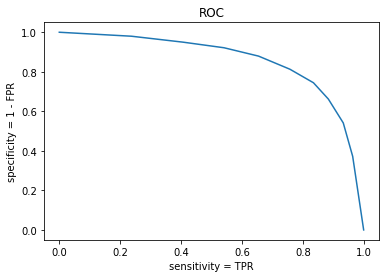

In [59]:
#note TPR = sensitivity, FPR = 1 - specificity
#FPR is important because we want to avoid overdosing
plt.plot(sensitivity, specificity)
plt.xlabel('sensitivity = TPR')
plt.ylabel('specificity = 1 - FPR')
plt.title('ROC')

print('auc')
print(auc(sensitivity,specificity)) #auc takes in arguments (x,y)

In [55]:
# Logistic Regression with L1 regularization
alpha = np.logspace(-3,3,7)
C = 1/alpha
threshold = np.arange(0,1.1,0.1)
accuracy = np.zeros( (len(C) , len(threshold)) )
sensitivity = np.zeros( (len(C) , len(threshold)) )
specificity = np.zeros( (len(C) , len(threshold)) )
precision = np.zeros( (len(C) , len(threshold)) )

for k in range(len(alpha)):
    log_regressor_L1reg = LogisticRegression(penalty = 'l1', C = C[k]) #set L2 penalty, C is inverse of reg strength
    log_regressor_L1reg.fit(X_train,y_train)

    #predict = log_regressor.predict(X_val) #this implements default threshold of 0.5

    for i in range(len(threshold)):

        predict = (log_regressor_L1reg.predict_proba(X_val)[:,1] >= threshold[i]).astype(int)

        TN, FP, FN, TP = confusion_matrix(y_val,predict).ravel()

        accuracy[k,i] = np.mean(predict == y_val)
        sensitivity[k,i] = TP / (TP + FN)
        specificity[k,i] = TN / (TN + FP)
        precision[k,i] = TP / (TP + FP)

recall = sensitivity.copy()

print('accuracy values')
print(accuracy)
print('sensitivity values')
print(sensitivity)
print('specificity values')
print(specificity)

C:\Users\zhiqi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zhiqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\zhiqi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zhiqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\zhiqi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zhiqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in longlo

accuracy values
[[0.43841808 0.63728814 0.70960452 0.75480226 0.77740113 0.78644068
  0.77288136 0.7559322  0.71186441 0.65875706 0.56158192]
 [0.43841808 0.63502825 0.71073446 0.75819209 0.77966102 0.78757062
  0.7740113  0.75706215 0.71299435 0.65875706 0.56158192]
 [0.43841808 0.63163842 0.71299435 0.75932203 0.78418079 0.78757062
  0.77966102 0.75480226 0.71186441 0.65423729 0.56158192]
 [0.43841808 0.62259887 0.70169492 0.7480226  0.78079096 0.79548023
  0.76949153 0.74463277 0.70621469 0.63954802 0.56158192]
 [0.43841808 0.58870056 0.68587571 0.73559322 0.7740113  0.78757062
  0.75367232 0.72768362 0.68135593 0.61242938 0.56158192]
 [0.43841808 0.4440678  0.55480226 0.65988701 0.74915254 0.74576271
  0.67683616 0.61129944 0.57627119 0.56497175 0.56158192]
 [0.43841808 0.43841808 0.43841808 0.43841808 0.43841808 0.55141243
  0.56158192 0.56158192 0.56158192 0.56158192 0.56158192]]
sensitivity values
[[1.         0.96134021 0.93041237 0.8814433  0.82474227 0.75515464
  0.65206186 0

C:\Users\zhiqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\zhiqi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zhiqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\zhiqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\zhiqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\zhiqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\zhiqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in longlong_scalars


auc
[0.85430884 0.85603311 0.85819557 0.85618868 0.8515578  0.81536383
 0.4912283 ]


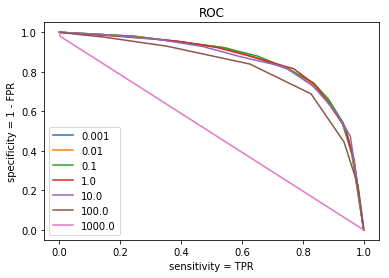

In [56]:
#note TPR = sensitivity, FPR = 1 - specificity
#FPR is important because we want to avoid overdosing
num = len(alpha)
AUC = np.zeros(num)
for i in range(num):
    plt.plot(sensitivity[i,:], specificity[i,:], label = alpha[i])
    AUC[i] = auc(sensitivity[i,:],specificity[i,:])
    
plt.xlabel('sensitivity = TPR')
plt.ylabel('specificity = 1 - FPR')
plt.legend()
plt.title('ROC')
plt.savefig('logreg_L1regularized_ROC.png')

print('auc')
print(AUC) #auc takes in arguments (x,y)

In [18]:
best_reg_strength = alpha[np.argmax(AUC)]
print(best_reg_strength)
best_auc = AUC[np.argmax(AUC)]
print(best_auc)

0.1
0.858428924059823


## SVM classification

In [52]:
from sklearn.svm import SVC

gamma = np.logspace(-5,1,7)
accuracy = np.zeros(len(gamma))
sensitivity = np.zeros(len(gamma))
specificity = np.zeros(len(gamma))
precision = np.zeros(len(gamma))

for i in range(len(gamma)):
    
    SV_classifier = SVC(gamma = gamma[i], kernel = 'rbf', random_state = 0)
    SV_classifier.fit(X_train,y_train)

    predict = SV_classifier.predict(X_val)

    TN, FP, FN, TP = confusion_matrix(y_val,predict).ravel()

    accuracy[i] = np.mean(predict == y_val)
    sensitivity[i] = TP / (TP + FN)
    specificity[i] = TN / (TN + FP)
    precision[i] = TP / (TP + FP)

recall = sensitivity.copy()

print('accuracy values')
print(accuracy)
print('sensitivity values')
print(sensitivity)
print('specificity values')
print(specificity)


C:\Users\zhiqi\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in longlong_scalars


accuracy values
[0.56158192 0.71412429 0.77175141 0.79322034 0.77853107 0.59322034
 0.56045198]
sensitivity values
[0.         0.54123711 0.70103093 0.76546392 0.77061856 0.12113402
 0.0128866 ]
specificity values
[1.         0.84909457 0.82696177 0.81488934 0.78470825 0.96177062
 0.98792757]


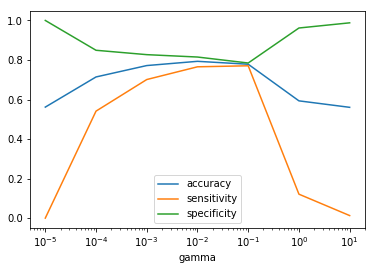

In [54]:
plt.plot(gamma,accuracy, label = 'accuracy')
plt.plot(gamma,sensitivity, label = 'sensitivity')
plt.plot(gamma,specificity, label = 'specificity')
plt.legend()
plt.xscale('log')
plt.xlabel('gamma')
plt.savefig('SVM_classifier.png')

## prediction on test set for best model

In [64]:
# Best Model is Logistic Regression with L2 regularization, reg strength = 1

log_regressor_L2reg = LogisticRegression(penalty = 'l2', C = 1) #set L2 penalty
log_regressor_L2reg.fit(X_train,y_train)

#predict = log_regressor.predict(X_val) #this implements default threshold of 0.5

threshold = 0.5 
predict = (log_regressor_L2reg.predict_proba(X_val)[:,1] >= threshold).astype(int)

TN, FP, FN, TP = confusion_matrix(y_val,predict).ravel()

accuracy = np.mean(predict == y_val)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)

recall = sensitivity.copy()

print('accuracy values')
print(accuracy)
print('sensitivity values')
print(sensitivity)
print('specificity values')
print(specificity)

accuracy values
0.7954802259887006
sensitivity values
0.7680412371134021
specificity values
0.8169014084507042


C:\Users\zhiqi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
